#Монтируем гугл диск 
(выполнить ячейку: shift+enter)

In [1]:
from google.colab import drive  
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Переходим в директорию с проектом (для удобства). Это папку необходимо создать. Можно руками в гугл диске, можно здесь через mkdir
#Также внутри images_compare создайте папку model_folder
#Не забудьте создать папки, это важно.

In [2]:
cd drive/MyDrive/images_compare

/content/drive/MyDrive/images_compare


#Импорт необходимых библиотек

In [3]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.datasets import mnist
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Lambda
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2

#Функция для создания модели

In [7]:
#Добавил немного описания, но не думаю, что вам это нужно. Однако если захотите углубиться, всё легко гуглится по этим названиям.
def build_model(inputShape):
    # Определяем вход
    inputs = Input(inputShape)
    # Первый слой по порядку: свертка - функция активации "relu" - пулинг - дропаут
    x = Conv2D(64, (2, 2), padding="same", activation="relu")(inputs)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.3)(x)
    # Второй: свертка - функция активации "relu" - пулинг - дропаут
    x = Conv2D(64, (2, 2), padding="same", activation="relu")(x)
    x = MaxPooling2D(pool_size=2)(x)
    x = Dropout(0.3)(x)
    # Выход
    pooledOutput = GlobalAveragePooling2D()(x)
    outputs = Dense(48)(pooledOutput)
    # Само построение модели
    model = Model(inputs, outputs)
    
    return model

In [8]:
#Скачиваем датасет, это знаменитый MNIST. Никогда его не использовал, но наконец-то пригодился
(trainX, trainY), (testX, testY) = mnist.load_data()
trainX = trainX / 255.0 # /255 чтобы значения были типа float в диапазоне [0-1]
testX = testX / 255.0

In [9]:
#Создаем структуру, в которую перезапишем изображения с измененным размером (изначально они были 28х28, станут такими, как решите, переменная IMG_SIZE).
#Лучше делать ресайз в квадратные картинки, какими они и были изначально, поэтому вместо Hight, Weight используем одну переменную IMG_SIZE. Можете поменять, как вам будет удобно и перейти к W,H.
#n_of_images_from_ds - количество изображений из датасета, которое вы хотите взять, дальше увидите.
IMG_SIZE = 50
n_of_images_from_ds = 10000
trainXX = np.ones((n_of_images_from_ds,IMG_SIZE,IMG_SIZE))
testXX = np.ones((n_of_images_from_ds//5,IMG_SIZE,IMG_SIZE))

#Теперь перебираем наш датасет (количество изображений, которое указали выше в n_images_from_ds), делаем ресайз каждого изображения и записываем его в новую структуру, где есть только нужные нам картинки

In [10]:
for n in range(len(trainX)): #перебор от 0 до 10000 в нашем случае
    if n <= (n_of_images_from_ds-1): #
      newimage = cv2.resize(trainX[n], (IMG_SIZE,IMG_SIZE), interpolation = cv2.INTER_AREA) #ресайз, понятно. Функцию интерполяции можете использовать любую, но для апскейла лучше эту.
      trainXX[n] = newimage #перезапись ресайзнутой картинки в нужную ячейку

In [11]:
for n in range(len(testX)):  
  if n <= (n_of_images_from_ds//5-1):
    newimage = cv2.resize(testX[n], (IMG_SIZE,IMG_SIZE), interpolation = cv2.INTER_AREA)
    testXX[n] = newimage

#Сейчас массив изображений имеет форму (10000,50,50), нужно добавить измерение, отражающее канал, чтобы стало (10000,50,50,1), 1 значит, что изображение грейскейл. Если 3 (как при загрузке любого изображения), то это цветное RGB, BGR. Можете посмотреть - trainXX.shape

In [12]:
trainXX = np.expand_dims(trainXX, axis=-1)
testXX = np.expand_dims(testXX, axis=-1)

В пару из trainXX будет ставиться trainYY, а количество у нас будет отличаться от дефолтного (60000), поэтому

In [13]:
trainYY = [] 
testYY = []
for x in range(n_of_images_from_ds):
  trainYY.append(x)
trainYY = np.asarray(trainYY)

for x in range(n_of_images_from_ds//5):
  testYY.append(x)
testYY = np.asarray(testYY)

In [14]:
#Функция, чтобы генерировать пары
#Вы ей воспользуетесь один раз, чтобы сгенерировать пары для обучения, не расписываю
def make_pairs(images, labels):
    # Создаем вда пустых списка, хранящих пары
    pairImages = []
    pairLabels = []
    # Считаем число классов в датасете, чтобы отличать каждый класс по индексу     
    numClasses = len(np.unique(labels))
    idx = [np.where(labels == i)[0] for i in range(0, numClasses)]    
    for idxA in range(len(images)):        
        currentImage = images[idxA]
        label = labels[idxA]
        
        idxB = np.random.choice(idx[label])
        posImage = images[idxB]
        
        pairImages.append([currentImage, posImage])
        pairLabels.append([1])
        
        negIdx = np.where(labels != label)[0]
        negImage = images[np.random.choice(negIdx)]
        
        pairImages.append([currentImage, negImage])
        pairLabels.append([0])
    
    return np.array(pairImages), np.array(pairLabels)

In [15]:
#Генерируем пары
(pairTrain, labelTrain) = make_pairs(trainXX, trainYY)
(pairTest, labelTest) = make_pairs(testXX, testYY)

In [16]:
#конфигурируем модель, чтобы считать евклидово расстояние. Оно нужно для дальнейшего расчет коэффициента различия
imgA = Input((IMG_SIZE,IMG_SIZE,1)) 
imgB = Input((IMG_SIZE,IMG_SIZE,1))
Extractor = build_model((IMG_SIZE,IMG_SIZE,1)) 
A = Extractor(imgA)
B = Extractor(imgB)

In [17]:
#Функция для расчета евклидова расстояния
def euclidean_distance(vectors):    
    (A, B) = vectors
    sumSquared = K.sum(K.square(A - B), axis=1, keepdims=True)    
    return K.sqrt(K.maximum(sumSquared, K.epsilon()))

In [18]:
#Определяем выход модели и объявляем её
distance = Lambda(euclidean_distance)([A, B])
model = Model(inputs=[imgA, imgB], outputs=distance)

In [19]:
#Удалим неиспользуемые структуры для освобождения ОЗУ (правый верхний угол, можно следить)
del trainXX
del testXX

In [20]:
#Определяем функцию потерь (самая удобная, для подсчета разницы, их много в гугле)
def loss(y, preds, margin=1):    
    y = tf.cast(y, preds.dtype)    
    squaredPreds = K.square(preds)
    squaredMargin = K.square(K.maximum(margin - preds, 0))
    loss = K.mean(y * squaredPreds + (1 - y) * squaredMargin)    
    return loss

In [21]:
#Компилируем модель с функцией потерь и оптимайзером "Адам", всё гуглится..
model.compile(loss=loss, optimizer="adam")

In [22]:
#Запускаем обучение, советую эпох 200, но это будет мало (посмотрите на тестах), учитывая, что данных недостаточно, ведь весь датасет это 60000 изображений.
#В дальнейшем увеличьте количество изображений (переменная n_of_images_from_ds) и эпох (epochs).
history = model.fit([pairTrain[:, 0], pairTrain[:, 1]], labelTrain[:],
                    validation_data=([pairTest[:, 0], pairTest[:, 1]], labelTest[:]),
                    batch_size=64, epochs=100)

Epoch 1/10
313/313 [==============================] - 7s 14ms/step - loss: 0.1321 - val_loss: 0.0505
Epoch 2/10
313/313 [==============================] - 4s 12ms/step - loss: 0.0640 - val_loss: 0.0426
Epoch 3/10
313/313 [==============================] - 4s 12ms/step - loss: 0.0575 - val_loss: 0.0376
Epoch 4/10
313/313 [==============================] - 4s 12ms/step - loss: 0.0556 - val_loss: 0.0364
Epoch 5/10
313/313 [==============================] - 4s 12ms/step - loss: 0.0533 - val_loss: 0.0403
Epoch 6/10
313/313 [==============================] - 4s 12ms/step - loss: 0.0489 - val_loss: 0.0255
Epoch 7/10
313/313 [==============================] - 4s 12ms/step - loss: 0.0374 - val_loss: 0.0238
Epoch 8/10
313/313 [==============================] - 4s 12ms/step - loss: 0.0353 - val_loss: 0.0234
Epoch 9/10
313/313 [==============================] - 4s 12ms/step - loss: 0.0328 - val_loss: 0.0221
Epoch 10/10
313/313 [==============================] - 4s 12ms/step - loss: 0.0321 - val_lo

In [23]:
#Сохраняем модель, для того, чтобы можно было её скачать и всегда использовать. Тестировать можете и здесь, но лично мне удобнее на локальной машине
model.save("model_folder")
#можете посмотреть на диске, в этой папке модель будет называться saved_model.pb
#Для того, чтобы её использовать в дальнейшем в тестах, копируйте не только её, но и все файлы и папки в папке "model_folder"

INFO:tensorflow:Assets written to: model_folder/assets


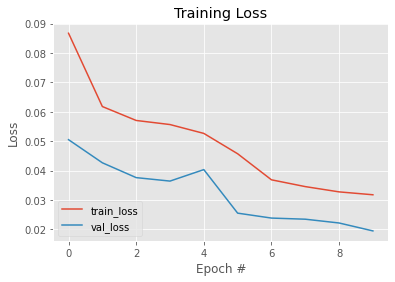

In [28]:
#Если хотите, постройте график обучения
def plotting(H, plotPath):    
    plt.style.use("ggplot")
    plt.figure()
    plt.plot(H.history["loss"], label="train_loss")
    plt.plot(H.history["val_loss"], label="val_loss")
    plt.title("Training Loss")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss")
    plt.legend(loc="lower left")
    plt.savefig(plotPath)

plotting(history, 'training')

In [ ]:
#Вот и всё! Далее можно скачать модель (обязательно все файлы, не только saved_model.pb) и протестировать.
#Чтобы сменить GPU на CPU: среда выполнения - сменить среду выполнения - аппаратный ускоритель.
#Гугл ограничивает работу на GPU 8-ю часами в сутки. Так что если не проводите обучение, рекомендую использовать CPU, там нет ограничений.
#В качестве бонуса и по секрету: стандартные блокноты colab имеют ограничение ОЗУ в 12 гб. Этот блокнот - 25 гб.